# RNN
RNN with some bonus stuffs re: helper class that generates the data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import matplotlib.pyplot as plt

In [17]:
# this awesome idea of excapsulating the logic of fetching the test data
# basically we just generate y = sin(x), where x = time

class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        # random starting point
        rand_start = np.random.rand(batch_size,1)
        
        # convert to time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        # create the batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

In [18]:
tsd = TimeSeriesData(250,0,10)

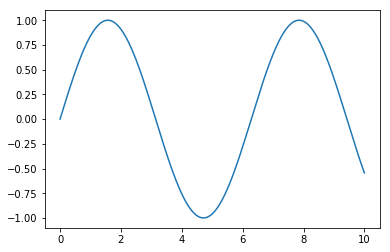

In [19]:
plt.plot(tsd.x_data,tsd.y_true)

In [20]:
num_time_steps = 30

In [21]:
y1,y2,ts = tsd.next_batch(1,num_time_steps,True)

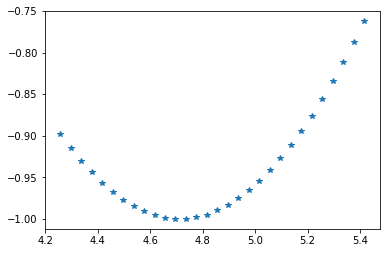

In [24]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

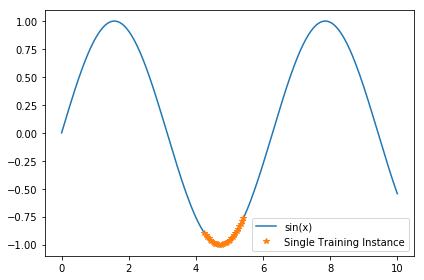

In [25]:
plt.plot(tsd.x_data,tsd.y_true,label='sin(x)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label="Single Training Instance")

plt.legend()
plt.tight_layout()

## Training Data

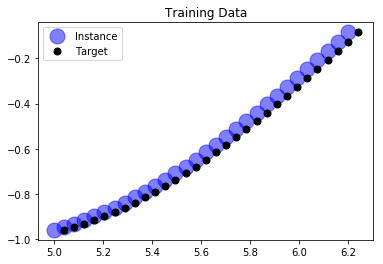

In [29]:
train_inst = np.linspace(5, 5 + tsd.resolution*(num_time_steps+1), num_time_steps+1)
plt.title('Training Data')
plt.plot(train_inst[:-1],tsd.ret_true(train_inst[:-1]),'bo',markersize=15,alpha=0.5,label='Instance')
plt.plot(train_inst[1:],tsd.ret_true(train_inst[:-1]),'ko',markersize=7,label='Target')
plt.legend()